## ICESat-2 Superelevation Finder 1000

Fill in the widget with the path to where the data will be stored. Then enter the width of the channel (measured externally)

In [1]:
import os
import ee
import geemap
import logging
logging.getLogger('shapely.geos').setLevel(logging.CRITICAL)
from sliderule import icesat2
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import warnings
import rasterio as rio
from rasterio.features import shapes
from ipywidgets import interact, widgets
from IPython.display import display
from utils import zoom_center, otsu, plot_comparison
from fiona import errors
import folium
import geopandas as gpd
import geemap.colormaps as gcm
import pandas as pd
from skimage.morphology import skeletonize, binary_dilation, skeletonize_3d   # noqa
from skimage.morphology import white_tophat, remove_small_objects
from skimage.morphology import disk  # noqa
from skimage import filters
import math
from shapely.geometry import Polygon
import numpy as np
os.environ["PLANET_API_KEY"] = "722017f6234b4160aa8d26fc6d39fa31"
import collections
collections.Callable = collections.abc.Callable
import plotly.express as px

try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
ee.Initialize()
Map = geemap.Map()

text = widgets.Text(
    placeholder='Folder Name',
    description='Path:',
    disabled=False
)

width = widgets.Text(
    placeholder='Width',
    description='',
    disabled=False
)



display(text)
display(width)

/Users/jakegearon/opt/anaconda3/envs/IS2SE/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Text(value='', description='Path:', placeholder='Folder Name')

Text(value='', placeholder='Width')

#### Bookkeeping

check to see if the files already exist in this directory to avoid redundant computation...

In [2]:
#set data directories, define the filenames for later
try:
    text = text.value
    out_path = os.path.join(os.getcwd(), text)
except (AttributeError, NameError):
    out_path = os.path.join( os.getcwd(), text)
    pass
try:
    width = width.value
except (AttributeError, NameError):
    pass
os.makedirs(out_path, exist_ok=True)
data_path = os.path.join(out_path, 'data')
os.makedirs(data_path, exist_ok=True)
channel_outline_fname = os.path.join(out_path, text+'_channeloutline.shp')
full_data_gdf_fname = os.path.join(data_path, text+'_full_dataset.feather')
gdf_watermask_fname = os.path.join(out_path, text+'_watermask.geojson')
out_tiff_fname = os.path.join(out_path,text+".tif")
out_mask_fname = os.path.join(out_path,text+"_mask.tif") 
skeleton_fname = os.path.join(out_path,text+"_skel.tif")
gdf_skel_fname = os.path.join(out_path, text+"_skel.shp")
cleaned_out_mask_fname = os.path.join(out_path,text+"_make_cleaned.tif")
gdf_lines_fname = os.path.join(out_path, text+"_lines.shp")

# see if we've already created these files... if not, let us know
try:
    out_tiff = os.path.join(out_path, text+".tif")
    gdf_watermask = gpd.read_file(gdf_watermask_fname)
    gdf_skel = gpd.read_file(gdf_skel_fname)
    
    
except errors.DriverError:
    print("need watermask..need buffers...")

try:
    full_data_gdf = gpd.read_feather(full_data_gdf_fname)
except FileNotFoundError:
    print("need to run sliderule...")

need watermask..need buffers...
need to run sliderule...


### Draw an ROI on the map
the ROI can be a square, circle, or polygon and can be drawn in the interactive map below

In [34]:
#todo labels for Avulsions
Map = geemap.Map()
#add planet background
Map.add_planet_by_quarter(year=2021, quarter=2)

def load_layer():
    global roi
    roi = geemap.shp_to_ee(channel_outline_fname)
    Map.addLayer(roi, {}, "ROI")
    Map.centerObject(roi.geometry())
    return Map
    

def refresh_layer():
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if channel_outline_fname:
            try:
                os.remove(channel_outline_fname)
            except FileNotFoundError:
                pass
        #try:
        Map.remove_drawn_features()
        Map.remove_ee_layer("MNDWI")
        Map.remove_ee_layer("Channel Mask")
        Map.remove_ee_layer("Cleaned Watermask Vector")
        Map.remove_ee_layer("skel_ee")
        #except Exception:
        #    print(Exception)
            
        
    
def on_click_refresh(x):
    refresh_layer()

def on_click_compute_mndwi(x):
    compute_mndwi()
    
def on_click_compute_vector(x):
    compute_mask()
    
def on_click_fetch_icesat2(x):
    fetch_icesat2()
    
button = widgets.Button(
    description='Clear ROI', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='CLEAR ROI',
    button_style='danger'# (FontAwesome names without the `fa-` prefix)
)


layout = widgets.Layout(width='auto', height='40px') #set width and height
button_mndwi = widgets.Button(
    description='Compute MNDWI', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Compute MNDWI',
    icon='water-arrow-down',
    display='flex',
    flex_flow='column',
    align_items='stretch',
    button_style='info',
    style= {'description_width': 'initial'}# (FontAwesome names without the `fa-` prefix)
)

button_vector = widgets.Button(
    description='Compute Vectors', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Compute Vectors',
    button_style='info'# (FontAwesome names without the `fa-` prefix)
)

button_icesat2 = widgets.Button(
    description='Fetch ICESat2', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Fetch ICESat2',
    button_style='info'# (FontAwesome names without the `fa-` prefix)
)


def compute_mndwi():
    # Get the DrawControl
    roi = Map.draw_last_feature
    geemap.ee_to_shp(ee.FeatureCollection(roi), channel_outline_fname)
    if os.path.isfile(out_tiff_fname) is True:
        os.remove(channel_outline_fname)
    collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2018-01-01', '2020-03-31').filterBounds(roi.geometry()).filterMetadata('CLOUD_COVER', 'less_than', 10).sort("CLOUD_COVER")
    im = collection.median()
    im = im.clip(roi.geometry())
    mndwi = im.normalizedDifference(['SR_B3', 'SR_B6'])

    keep_running = True
    while (keep_running):
        for scale in range(30, 150, 10):
            print("Trying to export at {} meters/pixel...".format(scale)) 
            if os.path.isfile(out_tiff_fname) is False:
                geemap.ee_export_image(mndwi, out_tiff_fname, scale=scale, region=roi.geometry())
            else:
                keep_running = False
                break   
    print("downloaded at {} m/pixel".format(scale))
    palette = list(gcm.palettes.hsv.n08)
    histogram = mndwi.reduceRegion(**{
      'reducer': ee.Reducer.histogram(255),
      'geometry': roi.geometry(),
      'scale': scale,
      'bestEffort': True
    })
    # Return the DN that maximizes interclass variance in B5 (in the region).
    threshold = otsu(histogram.get('nd'))
    print('threshold', threshold.getInfo())
    classA = mndwi.select('nd').gt(threshold) 
    channel = classA.updateMask(classA)
    Map.addLayer(mndwi, {'palette': palette}, "MNDWI")
    Map.addLayer(channel, {}, 'Channel Mask')
    Map.centerObject(channel.geometry())
    if os.path.isfile(out_mask_fname):
            os.remove(out_mask_fname)
    geemap.ee_export_image(channel, out_mask_fname, scale=scale, region=roi.geometry())
    
def compute_vector():
    from skimage.morphology import binary_closing, binary_dilation, binary_erosion
    from skimage.morphology import star, flood_fill
    mask = None
    footprint = disk(2)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with rio.open(out_mask_fname, 'r+') as src:
            kwds = src.profile
            image = src.read(1)
            #b_di = binary_dilation(image, footprint=footprint)
            rm_sh = remove_small_objects(image>0, image.shape[1]/2)
            rm_sh = rm_sh.astype('uint8')
            sk = skeletonize(rm_sh == 1)
            sk = sk.astype('uint8')
            results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(rm_sh, mask=mask, transform=src.transform, connectivity=8)))
            geoms = list(results)
            gdf_watermask = gpd.GeoDataFrame.from_features(geoms, crs='epsg:4326')
            print(len(gdf_watermask.geometry))
            gdf_watermask = gdf_watermask.query('raster_val ==1')
            gdf_watermask = gdf_watermask[gdf_watermask.geometry.area == gdf_watermask.geometry.area.max()]
            gdf_watermask['geometry'] = gdf_watermask.geometry.unary_union
            gdf_watermask = gdf_watermask[gdf_watermask.geometry.area == gdf_watermask.geometry.area.max()]
            print(type(gdf_watermask.geometry))
            gdf_watermask.to_file(gdf_watermask_fname)
            results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(sk, mask=mask, transform=src.transform, connectivity=8)))
            geoms = list(results)
            gdf_skel = gpd.GeoDataFrame.from_features(geoms, crs='epsg:4326')
            gdf_skel = gdf_skel.query('raster_val ==1')
            gdf_skel = gdf_skel[gdf_skel.geometry.geometry.area == gdf_skel.geometry.geometry.area.max()]
            gdf_skel.to_file(gdf_skel_fname)
            with rio.open(cleaned_out_mask_fname, 'w', **kwds) as src:
                src.write(rm_sh, 1)

            with rio.open(skeleton_fname, 'w', **kwds) as src:
                src.write(sk, 1)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        wm_ee = geemap.geopandas_to_ee(gdf_watermask)
        style = {'color': 'ff0000', 'width': 2}
        skel_ee = geemap.geopandas_to_ee(gdf_skel)
    vis_params_wm_ee = {
        'color': '#FFC0CB'  
    }
    Map.addLayer(wm_ee, vis_params_wm_ee, 'Cleaned Watermask Vector')
    Map.addLayer(skel_ee, {style}, 'Centerline')
    Map.centerObject(wm_ee.geometry())

def fetch_icesat2():
    from sliderule import icesat2
    icesat2.init("icesat2sliderule.org", verbose = True)
    region = icesat2.toregion(gdf_watermask_fname)[0]
    parms = {"poly": region, "srt": 4, "cnf": icesat2.CNF_SURFACE_HIGH} #"atl08_class": "atl08_ground"}
    # make request
    rsps = icesat2.atl03sp(parms)
    # analyze response
    df_sr = pd.DataFrame(rsps)
    print(len(df_sr))

button.on_click(on_click_refresh)
button_mndwi.on_click(on_click_compute_mndwi)
button_vector.on_click(on_click_compute_vector)
button_icesat2.on_click(on_click_fetch_icesat2)
display(widgets.HBox((button_mndwi, button_vector, button_icesat2, button)))
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Generating URL ...
Please wait ...
Data downloaded to /Users/jakegearon/PycharmProjects/IS2_Water_SE/newtest1/newtest1_channeloutline.shp
Trying to export at 30 meters/pixel...
downloaded at 30 m/pixel
threshold -0.025393363725368812
Generating URL ...
Please wait ...
An error occurred while downloading.


TypeError: /Users/jakegearon/PycharmProjects/IS2_Water_SE/newtest1/newtest1_mask.tif: No such file or directory

TypeError: /Users/jakegearon/PycharmProjects/IS2_Water_SE/newtest1/newtest1_mask.tif: No such file or directory

Generating URL ...
Please wait ...
Data downloaded to /Users/jakegearon/PycharmProjects/IS2_Water_SE/newtest1/newtest1_channeloutline.shp
Trying to export at 30 meters/pixel...
downloaded at 30 m/pixel
threshold -0.025393363725368812
Generating URL ...
Please wait ...
An error occurred while downloading.


TypeError: /Users/jakegearon/PycharmProjects/IS2_Water_SE/newtest1/newtest1_mask.tif: No such file or directory

In [31]:
Map.remove_ee_layer("MNDWI")

#### Compute MNDWI in GEE backend
the drawn ROI and the MNDWI raster are saved to the local path

In [85]:
if roi == None:
    roi = Map.draw_last_feature
    geemap.ee_to_shp(ee.FeatureCollection(roi), channel_outline_fname)
    if os.path.isfile(out_tiff_fname) is True:
        os.remove(channel_outline_fname)
else:
    os.path.join(out_path, "{}_info.txt".format(text))
collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2018-01-01', '2020-03-31').filterBounds(roi.geometry()).filterMetadata('CLOUD_COVER', 'less_than', 10).sort("CLOUD_COVER")
im = collection.median()
im = im.clip(roi.geometry())
mndwi = im.normalizedDifference(['SR_B3', 'SR_B6'])

            
keep_running = True
while (keep_running):
    for scale in range(30, 150, 10):
        print("Trying to export at {} meters/pixel...".format(scale)) 
        if os.path.isfile(out_tiff_fname) is False:
            geemap.ee_export_image(mndwi, out_tiff_fname, scale=scale, region=roi.geometry())
        else:
            keep_running = False
            break   
print("downloaded at {} m/pixel".format(scale))
palette = list(gcm.palettes.hsv.n08)
Map.addLayer(mndwi, {'palette': palette}, "MNDWI")
Map.centerObject(roi.geometry(), 12)

Trying to export at 30 meters/pixel...
downloaded at 30 m/pixel


#### Use Otsu's Method inside GEE to offload computation

_note: if the export fails, change the scale parameter in the `geemap.ee_export_image()` function_

In [15]:

geemap.ee_export_image(channel, out_mask_fname, scale=scale, region=roi.geometry())

    

threshold -0.009735102952346916
Generating URL ...
Please wait ...
Data downloaded to /Users/jakegearon/PycharmProjects/IS2_Water_SE/newtest/newtest_mask.tif


#### Channel Raster Mask Processing for Obtaining Centerline and Buffer Vectors
three separate steps occur here:
1. Convert the binary water mask to a skeleton (1px wide representation). To do this, the image needs to be clead up a bit. to do this I run the remove small holes operation from sci-kit image. This basically runs a filter with a specified size over the region and removes any coherent feature (connected values > 0) smaller than the specified size. I use half of the image length as a simple size value and it seems to work well.
2. Polygonize the cleaned watermask to a dataframe and save it locally
3. Quality check before querying data from SlideRule

In [155]:
from skimage.morphology import binary_closing, binary_dilation, binary_erosion
from skimage.morphology import star, flood_fill
mask = None
footprint = disk(2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with rio.open(out_mask_fname, 'r+') as src:
        kwds = src.profile
        image = src.read(1)
        #b_di = binary_dilation(image, footprint=footprint)
        rm_sh = remove_small_objects(image>0, image.shape[1]/2)
        rm_sh = rm_sh.astype('int32')
        sk = skeletonize(rm_sh == 1)
        sk = sk.astype('int32')
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) in enumerate(shapes(rm_sh, mask=mask, transform=src.transform, connectivity=8)))
        geoms = list(results)
        gdf_watermask = gpd.GeoDataFrame.from_features(geoms, crs='epsg:4326')
        print(len(gdf_watermask.geometry))
        gdf_watermask = gdf_watermask.query('raster_val ==1')
        gdf_watermask = gdf_watermask[gdf_watermask.geometry.area == gdf_watermask.geometry.area.max()]
        gdf_watermask['geometry'] = gdf_watermask.geometry.unary_union
        gdf_watermask = gdf_watermask[gdf_watermask.geometry.area == gdf_watermask.geometry.area.max()]
        print(type(gdf_watermask.geometry))
        gdf_watermask.to_file(gdf_watermask_fname)
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) in enumerate(shapes(sk, mask=mask, transform=src.transform, connectivity=8)))
        geoms = list(results)
        gdf_skel = gpd.GeoDataFrame.from_features(geoms, crs='epsg:4326')
        gdf_skel = gdf_skel.query('raster_val ==1')
        gdf_skel = gdf_skel[gdf_skel.geometry.geometry.area == gdf_skel.geometry.geometry.area.max()]
        gdf_skel.to_file(gdf_skel_fname)
        with rio.open(cleaned_out_mask_fname, 'w', **kwds) as src:
            src.write(rm_sh, 1)

        with rio.open(skeleton_fname, 'w', **kwds) as src:
            src.write(sk, 1)
                       


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    Map.centerObject(roi.geometry(), 12)
Map

8
<class 'geopandas.geoseries.GeoSeries'>


Map(bottom=3054923.0, center=[-8.229360943943316, -67.29593343279187], controls=(WidgetControl(options=['posit…

#### Query SlideRule

[From the website:](http://icesat2sliderule.org/)

>SlideRule is a server-side framework implemented in C++/Lua that provides REST APIs for processing science data and returning results. This enables researchers and other data systems to have low-latency access to generated data products using processing parameters supplied at the time of the request. SlideRule runs in AWS us-west-2 and has access to the official ICESat-2 datasets hosted by the NSIDC. While its web services can be accessed by any http client (e.g. curl), a Python client is provided that makes it easier to interact with SlideRule.
> 

If the polygon looks good we will just pass the water polygon to sliderule and ask for high confidence photons flagged as inland water by the processing algorithm. This method works well and cuts down on excess calls.

_note: don't worry about the WARNINGs and INFO readouts with 0 points returned, it's normal with the verbose = True_

In [20]:
from sliderule import icesat2
icesat2.init("icesat2sliderule.org", verbose = True)
region = icesat2.toregion(gdf_watermask_fname)[0]
parms = {"poly": region, "srt": 4, "cnf": icesat2.CNF_SURFACE_HIGH} #"atl08_class": "atl08_ground"}
# make request
rsps = icesat2.atl03sp(parms)
# analyze response
df_sr = pd.DataFrame(rsps)
print(len(df_sr))

ERROR:sliderule.icesat2:HTTP Request Error: Request-URI Too Large
ERROR:sliderule.icesat2:HTTP Request Error: Request-URI Too Large
INFO:sliderule.icesat2:Identified 55 resources to process
INFO:sliderule.icesat2:Allocating 21 workers across 7 processing nodes
INFO:sliderule.icesat2:0 points returned for ATL03_20190110154501_02010214_004_01.h5 (1 out of 55 resources)
INFO:sliderule.icesat2:0 points returned for ATL03_20190419230221_03310308_004_01.h5 (2 out of 55 resources)
INFO:sliderule.icesat2:0 points returned for ATL03_20191018142155_03310508_004_01.h5 (3 out of 55 resources)
INFO:sliderule.icesat2:0 points returned for ATL03_20190518213819_07730308_004_01.h5 (4 out of 55 resources)
INFO:sliderule.icesat2:0 points returned for ATL03_20190119032225_03310208_004_01.h5 (5 out of 55 resources)
INFO:sliderule.icesat2:638 points returned for ATL03_20190911040821_11460414_004_01.h5 (6 out of 55 resources)
INFO:sliderule.icesat2:0 points returned for ATL03_20190411112455_02010314_004_01.h

638


### Basic processing of ICESAT-2 photons

in order to pick out each track, we group by several variables `'rgt', 'cycle', 'track', 'pair'`. Each track gets a unique identifier. If any track has less than 5 points returned, skip it. (this can be adjusted depending on need). We save it as a .feather file for faster read/write speeds.

I've instituted some light filtering by taking out any points that lie greater than 3 std devs above the mean. Feel free to tweak this...



In [22]:
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
from scipy.stats import zscore
if len(df_sr) == 0:
    raise RuntimeError("No available granules")
gdf = gpd.GeoDataFrame(df_sr, geometry = df_sr.geometry)
g = gdf.groupby(['rgt', 'cycle', 'track', 'pair'])
p = 1
df_list = []
for k, v in g:
    v['lon'] = v.geometry.x
    v['lat'] = v.geometry.y
    v['UID'] = p
    ##### zscore filtering ####
    v['zscore'] = np.abs(zscore(v["height"]))
    v = v[v['zscore']<3]
    ##### zscore filtering ####
    v = gpd.GeoDataFrame(v, geometry = gpd.points_from_xy(x = v['lon'], y = v['lat'], crs="epsg:4326"))
    if len(v) > 5:
        df_list.append(v)
        v.reset_index().to_feather(os.path.join(data_path,'LINE_{}.feather'.format(p)))
        p += 1
full_data_gdf = pd.concat(df_list)
full_data_gdf.crs = "epsg:4326"
full_data_gdf.to_feather(full_data_gdf_fname)

NameError: name 'df_sr' is not defined

In [23]:
from shapely.geometry import Point, LineString
gdf_lines = full_data_gdf.groupby(['UID'])['geometry'].apply(lambda x: LineString(x.tolist()) if x.size > 1 else x.tolist())
gdf_lines_list = []


for i in gdf_lines.geometry.bounds.iterrows():
    gdf_lines_list.append(gpd.GeoDataFrame({"UID":i[0],"geometry":LineString([Point(i[1]['minx'], i[1]['miny']), Point(i[1]['maxx'], i[1]['maxy'])])}, index=[0]))
gdf_lines_sm = pd.concat(gdf_lines_list)
gdf_lines_sm.crs = "epsg:4326"
gdf_lines.to_file(gdf_lines_fname)
style = {'color': 'ff0000', 'width': 2}
skel_ee = geemap.geopandas_to_ee(gdf_skel)
Map.addLayer(skel_ee.style(**style), {}, 'Track Lines')
style = {'color': 'ffff00', 'width': 2}
lines_ee = geemap.geopandas_to_ee(gdf_lines_sm)
Map.addLayer(lines_ee.style(**style), {}, 'Track Lines')
Map

/Users/jakegearon/opt/anaconda3/envs/IS2SE/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/jakegearon/opt/anaconda3/envs/IS2SE/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Map(bottom=475700.0, center=[16.549328935473294, -15.31871795654297], controls=(WidgetControl(options=['positi…

In [42]:
inty = gpd.overlay(gdf_lines_sm, gdf_skel, 'intersection')
inty = inty.to_crs("epsg:3857")
inty['geometry'] = inty.geometry.buffer(int(width)//2)
inty = inty.to_crs("epsg:4326")
inty = inty.explode(index_parts=False)
gdf_ov = gpd.overlay(inty, gdf_skel, how='intersection')

In [50]:
gdf_skel.explode()

/var/folders/hw/h57q1f8s5gb97km03v5w6xm40000gn/T/ipykernel_62083/121028648.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_skel.explode()


,,raster_val,geometry
4,0,1.0,"POLYGON ((-15.38491 16.61784, -15.37898 16.617..."


In [51]:
import math
join_df = inty.sjoin(gdf_ov, how="left")
import numpy as np
ang_list = []
uid_list = []
for k, i in zip(join_df.index, join_df.iterrows()):

    try:
        uid = i[1].index
        arr = i[1]['geometry']
        polygon = Polygon(i[1]['geometry'].exterior.coords)

        gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])
        ov2 = gpd.overlay(gdf, gdf_skel, "intersection")
        bbox = ov2.geometry.bounds
        minx_bb = bbox.iloc[0, :]['minx']
        miny_bb = bbox.iloc[0, :]['miny']
        maxx_bb = bbox.iloc[0, :]['maxx']
        maxy_bb = bbox.iloc[0, :]['maxy']

        cl_angle = math.degrees(math.atan2(maxy_bb-miny_bb, maxx_bb-minx_bb))

        ri = i[1]['index_right']
        bbox = gdf_ov.bounds.iloc[int(ri)]

        ls_angle = math.degrees(math.atan2(bbox[3]-bbox[1], bbox[2]-bbox[0]))

        ang = (np.abs((((((cl_angle - ls_angle) % 360) + 540) % 360) - 180)))
        if ang > 20:
            ang_list.append(ang)
            uid_list.append(k)
            print(k, ang)

    except (AttributeError, ValueError):
        print('Multi or NaN')
        

print(len(ang_list))

 

Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN
Multi or NaN

In [10]:
ang_df=pd.DataFrame(ang_list, index=uid_list, columns = ["ANGLE"])
ang_df.index.name = 'UID'

list_of_indexes = ang_df.index.unique()

good_angle = full_data_gdf.loc[full_data_gdf['UID'].isin(list_of_indexes.values)]


### Visualize the Data

We're going to use plotly's mapbox function to plot these points, it handles them _really_ well natively, I think because it's built on java?

Plotly's functionality allows us to hover over the lines of interest.

_Note: in the development version of this notebook I'm beginning to institute angle thresholds so that only orthogonal lines get kept. For now, the easiest method is to identify interesting lines via...ocular inspection..._

In [121]:
fig = px.scatter_mapbox(good_angle, lat="lat", lon="lon", hover_data=["UID"], color='height') #color='se', hover_data=["uid"])
fig.update_layout(
    mapbox_style="white-bg", height=600,
    mapbox_layers=[
        {
            "below": "traces",
            "minzoom": 5,
            "maxzoom": 24,
            "sourcetype": "raster",
            "sourceattribution": "Google Satellite Imagery",
            "source": [
                "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}"
            ]
        }])

### Visualizing a single track

supply the UID from the line of interest and see the plot!

_some caveats: I have plotted a linear regression line automatically in the plots, this is more of a guide than anything else. Additionally, I've plotted latitude on the x-axis, this may have som undesired geometric effects. If this is the case, use the timestamp of the collected photon (next cell down). The seaborn `regplot()` won't work with timeseries data, however._

/Users/jakegearon/opt/anaconda3/envs/IS2SE/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



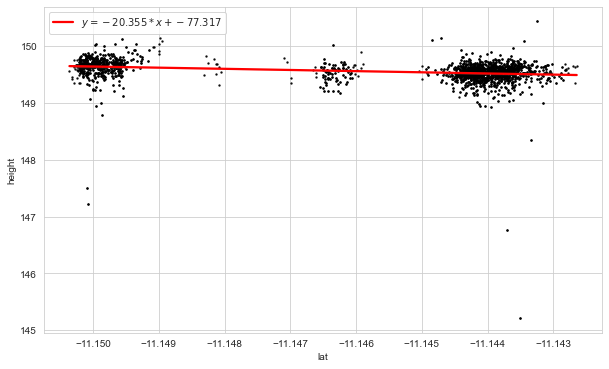

In [124]:
import seaborn as sns; sns.set_style("whitegrid")
from scipy import stats
track = 20

temp_df = good_angle.query("UID == {}".format(track))
temp_df.UID = temp_df.UID.astype('int')
fig, ax = plt.subplots(1, figsize=(10, 6))
slope, intercept, r_value, pv, se = stats.linregress(temp_df['lat'], temp_df['height'])
sns.regplot(data=temp_df, x="lat", y="height", scatter_kws={"color": "black", "s":2}, line_kws={"color": "red", 'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)}, ax=ax)
plt.legend()
plt.show()


#### Using the timestamp index..

<AxesSubplot:xlabel='time', ylabel='height'>

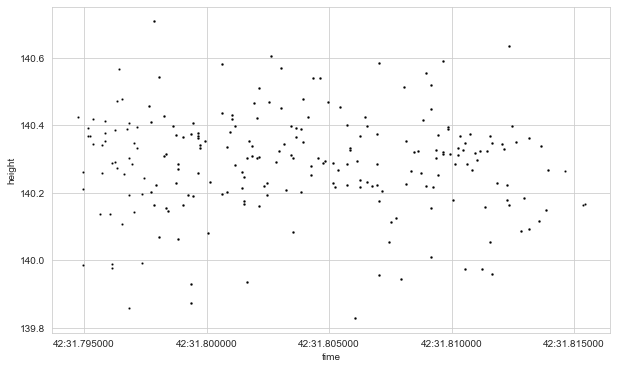

In [60]:
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.scatterplot(data=temp_df, x=temp_df.index, y="height", color='black', s=5, ax=ax)

To save the data as csv. just run this cell

In [ ]:
filename = "myfilename.csv"
full_data_gdf.to_file(os.path.join(out_path, filename))